In [ ]:
! pip install -U langchain-text-splitters langchain_huggingface sentence-transformers langchain_groq langchain-community langgraph python-dotenv faiss-cpu pypdf

In [33]:
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

In [34]:
load_dotenv()

True

In [35]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [36]:
loader = PyPDFLoader("intro-to-ml.pdf")
docs = loader.load()

In [37]:
len(docs)

392

In [38]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [39]:
len(chunks)

973

In [40]:
#embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L12-v2")

In [41]:
vector_store = FAISS.from_documents(chunks, embeddings)
vector_store

In [42]:
# Save the FAISS index
vector_store.save_local("faiss_index")

In [43]:
loaded_vector_store = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [44]:
retriever = loaded_vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [45]:
retriever.invoke("What is machine learning?")[0]

Document(id='37c76662-60a6-4119-9f45-ea115e565736', metadata={'producer': '3-Heights(TM) PDF Optimization Shell 5.9.1.5 (http://www.pdf-tools.com)', 'creator': 'AH CSS Formatter V6.2 MR4 for Linux64 : 6.2.6.18551 (2014/09/24 15:00JST)', 'creationdate': '2016-09-21T13:04:39+00:00', 'author': 'Andreas C. Müller and Sarah Guido', 'title': 'Introduction to Machine Learning with Python', 'trapped': '/False', 'moddate': '2020-08-19T07:09:16+02:00', 'source': 'intro-to-ml.pdf', 'total_pages': 392, 'page': 14, 'page_label': '1'}, page_content='Outside of commercial applications, machine learning has had a tremendous influ‐\nence on the way data-driven research is done today. The tools introduced in this book\nhave been applied to diverse scientific problems such as understanding stars, finding\ndistant planets, discovering new particles, analyzing DNA sequences, and providing\npersonalized cancer treatments.\nY our application doesn’t need to be as large-scale or world-changing as these exam‐

In [46]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [47]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [48]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [49]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [50]:
tool_node = ToolNode(tools)

In [51]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

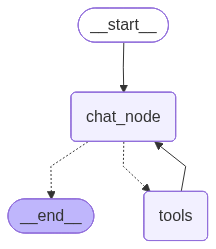

In [52]:
chatbot

In [53]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

In [54]:
print(result['messages'][-1].content)

The ideal value of K in KNN can be found by using the score method of the KNeighborsClassifier object, which computes the test set accuracy for the model. The value of K that results in the highest test set accuracy is the ideal value. In the provided pdf notes, the test set accuracy is about 0.97, which means that the model is correct 97% of the time for new irises. The code snippet provided shows how to apply the KNN algorithm using scikit-learn and how to compute the test set accuracy. The ideal value of K can be found by iterating over different values of K and computing the test set accuracy for each value. The value of K that results in the highest test set accuracy is the ideal value.
